## Transfer learn without one cycle policy

The aim of this code is to implement a plain transfer learned network to compare with Leslie Smiths one-cycle policy as implemented in fastai.

In [1]:
import sys
if sys.version_info[0] < 3:
    raise Exception("Must be using Python 3")

In [2]:
from __future__ import print_function, division

import torch
from torch import nn
import torch.optim as optim

In [3]:
from fastai import * # Probably imports tvm i.e. the torchvision models
from fastai.vision.learner import ConvLearner
from fastai.basic_data import DataBunch
from fastai.metrics import accuracy
from fastai.train import ShowGraph

In [4]:
# Import to stop displaying a progressbar
from fastprogress import force_console_behavior
import fastprogress
fastprogress.fastprogress.NO_BAR = False
# master_bar, progress_bar = force_console_behavior()

In [5]:
import numpy as np
import torchvision 
from torchsummary import summary
import torchvision.models as tvm

import matplotlib.pyplot as plt

import pickle
import time
import os
import copy

%matplotlib inline

In [6]:
import pixiedust

Pixiedust database opened successfully


In [7]:
from models import *
from utils import *
from data import *


/usr/local/home/akn36d/projects/pytorch_learn/transfer_learning/mlbkl/models.py:12: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')


In [8]:
# PRELIM Environment SETUP
model_name = 'tvm_resnet34' # <----------------
sys_name = 'R05' # System in which code is being run # <----------------
run_num_val = 1 # Each run reflects a fresh training of model with new parameters 
                # (i.e. when optimizer or loss is changed) it is dfferent from
                # train_num. 
train_num = 1 # Number of times this network has been trained with 
		      # previous weights but same param settings. If settings changed it
		      # should produce another config/log/weight file with the train_num in its 
		      # filename. 
            
run_num = sys_name + '_rPlainfit_epochs10' + str(run_num_val) # <----------------

# Set up environment paths
suite_fname, models_dir, log_dir_path, save_weights_path, config_path = run_environ_setup(model_name, run_num, train_num)

data_dir = 'mel_bkl'
class_names = ["mel","bkl"]

In [9]:
print(2*'************',' DIRECTORY INFO',2*'************')
print('The models will be stored in : {}'.format(models_dir))
print('The logs(images,metrics,folds) will be stored in : {}'.format(log_dir_path))
print('The weights will be stored in : {}'.format(save_weights_path))
print('The config info will be stored in : {}'.format(config_path))
print(2*'************','***************',2*'************')

************************  DIRECTORY INFO ************************
The models will be stored in : Model_runs
The logs(images,metrics,folds) will be stored in : Model_runs/tvm_resnet34_R05_rPlainfit_epochs101/logs
The weights will be stored in : tvm_resnet34_R05_rPlainfit_epochs101/weights
The config info will be stored in : Model_runs/tvm_resnet34_R05_rPlainfit_epochs101/config
************************ *************** ************************


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('GPU is available : {}'.format(torch.cuda.is_available()))
print(device)

GPU is available : True
cuda:0


In [11]:
# LOAD DATA
data_dir = 'mel_bkl'
class_names = ["mel","bkl"]

num_folds = 5
# Generate the folds for a 10-fold cross validation
np.random.seed(123)# to get same splits each time
fold10_cv = make_folds(data_dir, 
                       class_names, 
                       file_template='*.jpg', 
                       n_splits=num_folds, 
                       save_folds=True, 
                       fold_prefix='fold{}'.format(num_folds),
                       save_dir=log_dir_path)
pprint(fold10_cv)

[{'test': {'x': array(['mel_bkl/mel/ISIC_0027204.jpg', 'mel_bkl/mel/ISIC_0024640.jpg',
       'mel_bkl/mel/ISIC_0028003.jpg', 'mel_bkl/mel/ISIC_0033299.jpg',
       'mel_bkl/mel/ISIC_0031999.jpg', 'mel_bkl/mel/ISIC_0026247.jpg',
       'mel_bkl/mel/ISIC_0033099.jpg', 'mel_bkl/mel/ISIC_0026823.jpg',
       'mel_bkl/mel/ISIC_0033931.jpg', 'mel_bkl/mel/ISIC_0025121.jpg',
       'mel_bkl/mel/ISIC_0031303.jpg', 'mel_bkl/mel/ISIC_0028899.jpg',
       'mel_bkl/mel/ISIC_0032690.jpg', 'mel_bkl/mel/ISIC_0026989.jpg',
       'mel_bkl/mel/ISIC_0027604.jpg', 'mel_bkl/mel/ISIC_0033872.jpg',
       'mel_bkl/mel/ISIC_0031529.jpg', 'mel_bkl/mel/ISIC_0029092.jpg',
       'mel_bkl/mel/ISIC_0032110.jpg', 'mel_bkl/mel/ISIC_0033240.jpg',
       'mel_bkl/mel/ISIC_0027130.jpg', 'mel_bkl/mel/ISIC_0033819.jpg',
       'mel_bkl/mel/ISIC_0028969.jpg', 'mel_bkl/mel/ISIC_0033261.jpg',
       'mel_bkl/mel/ISIC_0032656.jpg', 'mel_bkl/mel/ISIC_0032836.jpg',
       'mel_bkl/mel/ISIC_0025800.jpg', 'mel_bkl/mel/ISIC_0027

### Training only the added last layers (head of n/w)
The __ConvLearner__ method creates a __Learner__ object from the data object and model inferred from it with the backbone given in arch. Specifically, it will cut the model defined by arch (randomly initialized if pretrained is False) at the last convolutional layer by default (or as defined in cut, see below) and add:

- an AdaptiveConcatPool2d layer,
- a Flatten layer,
- blocks of [nn.BatchNorm1d, nn.Dropout, nn.Linear, nn.ReLU] layers.

The blocks are defined by the lin_ftrs and ps arguments. Specifically, the first block will have a number of inputs inferred from the backbone arch and the last one will have a number of outputs equal to data.c (which contains the number of classes of the data) and the intermediate blocks have a number of inputs/outputs determined by lin_frts (of course a block has a number of inputs equal to the number of outputs of the previous block). The default is to have an intermediate hidden size of 512 (which makes two blocks model_activation -> 512 -> n_classes). 

NOTE: The current version of fastai has replaced the __ConvLearner__ class with the __create_cnn()__ as a method of its general Learner class

In [12]:
#%%pixie_debugger 
# Creating a array of numpy seed values to be used for each fold
rand_seed = np.r_[0:num_folds]
global class_names
for fold_num, fold in enumerate(fold10_cv):
    # Setting the seed for the fold
    np.random.seed(rand_seed)

    print(70*"=")
    print("FOLD - {}".format(fold_num))
    print(70*"=")
    # pprint(fold)

    train_files = fold["train"] 
    test_files = fold["test"]

    print('Number of training images in fold: ', len(train_files["x"]))
    print('Number of test images in fold: ', len(test_files["x"]))

    train_val_split = make_tr_val(file_list=train_files["x"], class_name_list=class_names, val_per=0.2)

    # # reducing training set size for faster debug
    # train_val_split['train']['x'] = train_val_split['train']['x'][0:100,...]
    # train_val_split['train']['y'] = train_val_split['train']['y'][0:100,...] 

    # x_train = train_val_split["train"]

    print('Number of training images: ',len(train_val_split['train']['x']))
    print('Number of val images: ', len(train_val_split['val']['x']))


    # y_train = train_val_split["train"]["y"]

    # x_val = train_val_split["val"]["x"]
    # y_val = train_val_split["val"]["y"]

    # Finding Training image set mean and std for normalization 
    find_mean = True
    if find_mean:
        try:
            f = open(os.path.join(suite_fname,'stats_fld{}.pkl'.format(fold_num)), 'rb')
            pop_mean, pop_std0, pop_std1 = pickle.load(f)
            f.close()
        except(FileNotFoundError):
            (pop_mean, pop_std0, pop_std1) = find_pop_mean_std(train_fold=train_val_split['train'], class_name_list=class_names)
            with open(os.path.join(suite_fname,'stats_fld{}.pkl'.format(fold_num)), 'wb') as f:
                pickle.dump((pop_mean, pop_std0, pop_std1),f)
    else: 
        (pop_mean, pop_std0, pop_std1) = ([0,0,0],[1,1,1],[1,1,1])

    # Specifying the data transforms
    data_transforms = {
                        'train': transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(pop_mean, pop_std0)]),
                        'val': transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize(pop_mean, pop_std0)])
                      }

    # Creating a dataloader for the test data
    test_dataset = kFolded_Dataset(fold_dict=test_files, class_names_list=class_names, transform=data_transforms['val'])
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=6, shuffle=True, num_workers=1)

    # Do dictionary comprehension to process data 
    image_dataset = {x: kFolded_Dataset_fastai(fold_dict=train_val_split[x], class_names_list=class_names, transform=data_transforms[x])
                                       for x in ['train', 'val']}   
    # print(image_dataset['train'].File_list[0])

    dataloaders = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size=6, shuffle=True, num_workers=1) 
                                                 for x in ['train', 'val']}

    # creating fastai databunches from the pytorch dataloaders
    data_bunches = DataBunch(train_dl=dataloaders['train'], 
                             valid_dl=dataloaders['val'], 
                             test_dl=test_dataloader,
                             device=device)

    dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'val']}
    class_names = image_dataset['train'].classes        

    # tensor_imshow(dataloaders=dataloaders, class_names=class_names, phase='train')

    # Finetuning a pre-trained model
    init_model = tvm.resnet34
    # print('\nThe initial model : {}'.format(init_model()))
    # Using the fastai learner class to fit my model
    learn = ConvLearner(data=data_bunches, arch=init_model, 
                        metrics=accuracy,
                        model_dir=models_dir)       
    learn.loss_func = nn.CrossEntropyLoss()

    # new_model = learn.model
    # print('\nThe new modified model : {}'.format(new_model))

    # Trying to find optimum base_lr to max_lr range
    lr_range_find = False
    if lr_range_find:
        learn.lr_find(start_lr=1e-4,end_lr=10,num_it=267) # From image we can see (0.00009 to 0.001) is a good range
                                                          # for cyclical learning
        fig = plt.figure()
        learn.recorder.plot()
        plt.xlabel('Learning rate')
        plt.ylabel('Validation Loss')
        plt.savefig('scheduler_plot.png', dpi=800)
        break
        
        # # fit the model 
    num_epochs = 10
    learn.fit(epochs=num_epochs, lr=0.001)

    # Plot the important stuff
    fig = plt.figure()    
    learn.recorder.plot_losses()
    plt.legend('training','validation')
    plt.title('Loss vs Num_its')
    loss_fname = os.path.join(log_dir_path,'model_fastai_fld_losses{}.png'.format(fold_num))
    plt.savefig(loss_fname, dpi=fig.dpi)

    fig = plt.figure() 
    learn.recorder.plot_lr(show_moms = True)
    lr_fname = os.path.join(log_dir_path,'model_fastai_fld_lr{}.png'.format(fold_num))
    plt.title('Learning Reate vs Num_its')
    plt.savefig(lr_fname, dpi=fig.dpi)

    fig = plt.figure() 
    learn.recorder.plot_metrics()
    plt.title('Accuracy vs Num_its')
    metrics_fname = os.path.join(log_dir_path,'model_fastai_fld_metrics{}.png'.format(fold_num))
    plt.savefig(metrics_fname, dpi=fig.dpi)

    # saving the model on the k-th fold
    model_fname = os.path.join(save_weights_path,"resnet34_fastai_fld{}".format(fold_num))
    learn.save(model_fname)

    # Pickle the metrics and loss vals
    with open(os.path.join(suite_fname,'train_info_fld{}.pkl'.format(fold_num)), 'wb') as f:
        pickle.dump([learn.recorder.lrs,
                     learn.recorder.losses,
                     learn.recorder.val_losses,
                     learn.recorder.metrics],f)

FOLD - 0
Number of training images in fold:  1769
Number of test images in fold:  443
Number of training images:  1415
Number of val images:  354
Number of images in training population : 1415
Processing ....
	Shape of train set : (1415, 3, 450, 600)
Processing Finished ....


Total time: 04:05
epoch  train loss  valid loss  accuracy
1      0.701583    0.548682    0.748588  (00:24)
2      0.637111    0.541479    0.740113  (00:24)
3      0.625973    0.502665    0.745763  (00:24)
4      0.579327    0.451173    0.782486  (00:24)
5      0.566544    0.445535    0.807910  (00:24)
6      0.545498    0.422789    0.841808  (00:24)
7      0.493586    0.362348    0.850282  (00:24)
8      0.496715    0.368737    0.864407  (00:24)
9      0.467945    0.380989    0.833333  (00:24)
10     0.526658    0.354448    0.870057  (00:24)



/opt/progs/conda3/envs/fastai/lib/python3.7/site-packages/matplotlib/legend.py:794: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/opt/progs/conda3/envs/fastai/lib/python3.7/site-packages/matplotlib/legend.py:794: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/opt/progs/conda3/envs/fastai/lib/python3.7/site-packages/matplotlib/legend.py:794: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format

FOLD - 1
Number of training images in fold:  1769
Number of test images in fold:  443
Number of training images:  1415
Number of val images:  354
Number of images in training population : 1415
Processing ....
	Shape of train set : (1415, 3, 450, 600)
Processing Finished ....


Total time: 04:04
epoch  train loss  valid loss  accuracy
1      0.665394    0.475971    0.782486  (00:24)
2      0.638375    0.483141    0.785311  (00:24)
3      0.541730    0.455394    0.802260  (00:24)
4      0.526524    0.431888    0.788136  (00:23)
5      0.499280    0.440029    0.788136  (00:24)
6      0.558303    0.452438    0.776836  (00:24)
7      0.514053    0.470391    0.782486  (00:24)
8      0.476114    0.418907    0.813559  (00:24)
9      0.485949    0.431214    0.819209  (00:24)
10     0.478061    0.411080    0.813559  (00:24)



/opt/progs/conda3/envs/fastai/lib/python3.7/site-packages/matplotlib/legend.py:794: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/opt/progs/conda3/envs/fastai/lib/python3.7/site-packages/matplotlib/legend.py:794: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/opt/progs/conda3/envs/fastai/lib/python3.7/site-packages/matplotlib/legend.py:794: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format

FOLD - 2
Number of training images in fold:  1769
Number of test images in fold:  443
Number of training images:  1415
Number of val images:  354
Number of images in training population : 1415
Processing ....
	Shape of train set : (1415, 3, 450, 600)
Processing Finished ....


Total time: 04:05
epoch  train loss  valid loss  accuracy
1      0.710243    0.650992    0.677966  (00:24)
2      0.603123    0.542892    0.745763  (00:24)
3      0.581934    0.519154    0.768362  (00:24)
4      0.545774    0.502202    0.745763  (00:24)
5      0.532760    0.515174    0.759887  (00:24)
6      0.480714    0.492872    0.771186  (00:24)
7      0.483188    0.467963    0.782486  (00:24)
8      0.524773    0.442861    0.796610  (00:24)
9      0.546561    0.468629    0.788136  (00:24)
10     0.473770    0.439843    0.790960  (00:24)



/opt/progs/conda3/envs/fastai/lib/python3.7/site-packages/matplotlib/legend.py:794: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/opt/progs/conda3/envs/fastai/lib/python3.7/site-packages/matplotlib/legend.py:794: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/opt/progs/conda3/envs/fastai/lib/python3.7/site-packages/matplotlib/legend.py:794: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format

FOLD - 3
Number of training images in fold:  1770
Number of test images in fold:  442
Number of training images:  1416
Number of val images:  354
Number of images in training population : 1416
Processing ....
	Shape of train set : (1416, 3, 450, 600)
Processing Finished ....


Total time: 04:05
epoch  train loss  valid loss  accuracy
1      0.718837    0.533318    0.723164  (00:24)
2      0.568371    0.521693    0.725989  (00:24)
3      0.579001    0.482269    0.757062  (00:24)
4      0.525758    0.462304    0.785311  (00:24)
5      0.514143    0.401028    0.810734  (00:25)
6      0.511539    0.421649    0.793785  (00:24)
7      0.482241    0.393288    0.813559  (00:24)
8      0.495030    0.419834    0.796610  (00:24)
9      0.525270    0.414677    0.813559  (00:24)
10     0.456076    0.416334    0.813559  (00:24)



/opt/progs/conda3/envs/fastai/lib/python3.7/site-packages/matplotlib/legend.py:794: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/opt/progs/conda3/envs/fastai/lib/python3.7/site-packages/matplotlib/legend.py:794: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/opt/progs/conda3/envs/fastai/lib/python3.7/site-packages/matplotlib/legend.py:794: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format

FOLD - 4
Number of training images in fold:  1771
Number of test images in fold:  441
Number of training images:  1416
Number of val images:  355
Number of images in training population : 1416
Processing ....
	Shape of train set : (1416, 3, 450, 600)
Processing Finished ....


Total time: 04:06
epoch  train loss  valid loss  accuracy
1      0.734877    0.572567    0.723944  (00:24)
2      0.654210    0.483912    0.757747  (00:24)
3      0.554393    0.488890    0.771831  (00:24)
4      0.550630    0.438257    0.794366  (00:24)
5      0.530428    0.414447    0.836620  (00:24)
6      0.527778    0.409676    0.814085  (00:24)
7      0.518566    0.417959    0.828169  (00:24)
8      0.511101    0.398991    0.828169  (00:24)
9      0.542414    0.423479    0.825352  (00:24)
10     0.464672    0.373199    0.847887  (00:24)



/opt/progs/conda3/envs/fastai/lib/python3.7/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/progs/conda3/envs/fastai/lib/python3.7/site-packages/matplotlib/legend.py:794: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/opt/progs/conda3/envs/fastai/lib/python3.7/site-packages/matplotlib/legend.py:794: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-le

<Figure size 432x288 with 0 Axes>

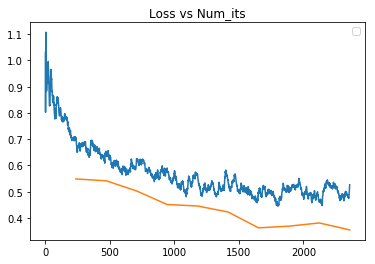

<Figure size 432x288 with 0 Axes>

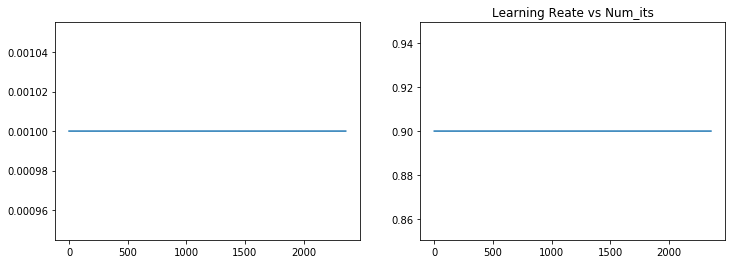

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

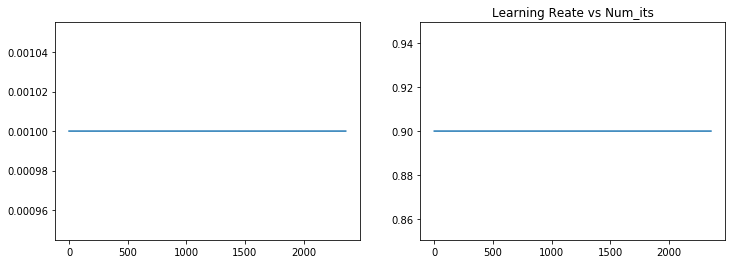

<Figure size 432x288 with 0 Axes>

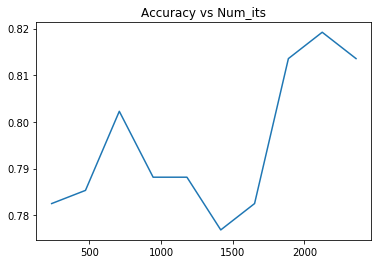

<Figure size 432x288 with 0 Axes>

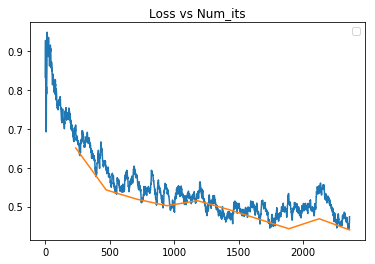

<Figure size 432x288 with 0 Axes>

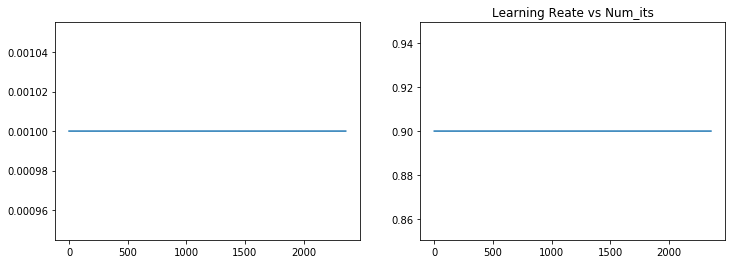

<Figure size 432x288 with 0 Axes>

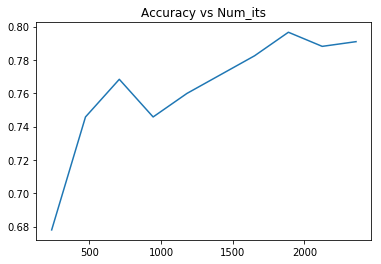

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

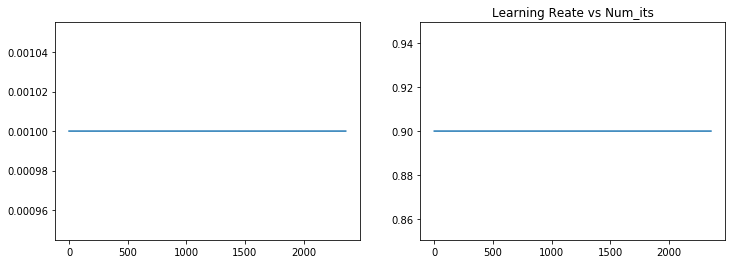

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

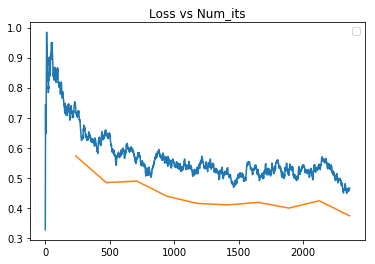

<Figure size 432x288 with 0 Axes>

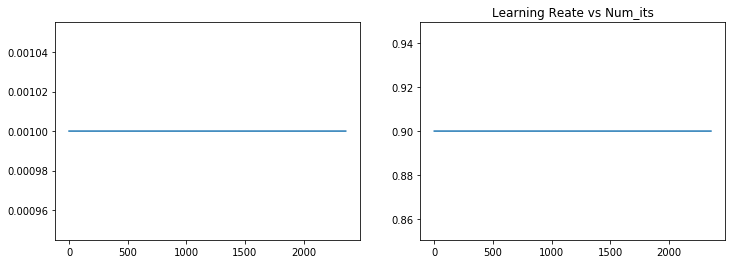

<Figure size 432x288 with 0 Axes>

In [13]:
plt.show()